In [53]:
import argparse
from tqdm import tqdm
import cv2
import torch
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# from petroleum import PetroleumDataset, collate_skip_empty, colors_pre_class
# from petroleum_dataset import PetroleumDataset, collate_skip_empty, colors_per_class
from petroleum_dataset import PetroleumDataset, collate_skip_empty
from resnet import ResNet101
import torchvision.models as modes

In [3]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']  # 提取网络结构
    model.load_state_dict(checkpoint['model_state_dict'])  # 加载网络权重参数
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [4]:
def fix_random_seeds():
    seed = 10
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

In [50]:
def get_features(dataset, batch, num_images):
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    # initialize our implementation of ResNet
    # model = modes.vgg16(pretrained=False)
    model = ResNet101(pretrained=True)
    # model = load_checkpoint(trained_model)
    model.eval()
    model.to(device)

    # read the dataset and initialize the data loader
    dataset = PetroleumDataset(dataset, num_images)
    print('======================')
    print(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, collate_fn=collate_skip_empty, shuffle=True)
    # print(dataloader)
    # print('++++++++++++++++++++++++')

    # we'll store the features as NumPy array of size num_images x feature_size
    features = None

    # we'll also store the image labels and paths to visualize them later
    labels = []
    image_paths = []

    for batch in tqdm(dataloader, desc='Running the model inference'):
        # print(batch)
        images = batch['image'].to(device)
        labels += batch['label']
        image_paths += batch['image_path']
        # print('+++++++++++=====================')
        # print(images)
        # print(labels)
        # print(set(labels))
        # print(image_paths)
        # print('==================+++++++++++++++++++')

        with torch.no_grad():
            output = model.forward(images)

        current_features = output.cpu().numpy()
        # print('=================================')
        # print(current_features)
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features

    return features, labels, image_paths, images

In [6]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    # print('rrrrrrrrrrrrrrrrrrrrrrrrrr')
    # print(x)
    starts_from_zero = x - np.min(x)
    # print(starts_from_zero)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [7]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    # 对图片调整大小
    image = cv2.resize(image, (image_width, image_height))
    return image

In [8]:
def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image

In [9]:
# 计算绘图坐标
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [10]:
# 可视化tsne图像
def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

In [11]:
def visualize_tsne_points(tx, ty, labels):
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        # add a scatter plot with the correponding color and label
        ax.scatter(current_tx, current_ty, c=color, label=label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # finally, show the plot
    plt.show()

In [12]:
def visualize_tsne(tsne, images, labels, plot_size=1000, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    # tsne是二维数组
    tx = tsne[:, 0]
    # print(tx)

    ty = tsne[:, 1]
    # print(ty)
    # print(np.min(ty))
    # print(np.max(ty))
    # print('++++++++++=======++++++++')

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

In [62]:
path = "D:\\中石油工作\\pytorch_classification-master\\data\\data_oil"
batch = 64
num_images = 1000
fix_random_seeds()

In [63]:
features, labels, image_paths, images = get_features(path, batch, num_images)

Running the model inference:   0%|                                                              | 0/16 [00:00<?, ?it/s]

Running the model inference: 100%|█████████████████████████████████████████████████████| 16/16 [01:41<00:00,  6.32s/it]


In [64]:
print(features.shape)

(1000, 2048)


In [65]:
# print(labels)
dict_list = {'seven': 7, 'four': 4, 'eight': 8, 'six': 6, 'two': 2, 'one': 1, 'five': 5, 'three': 3, 'nine': 9, 'twelve': 12, 'eleven': 11, 'fourteen': 14, 'ten': 10, 'therteen': 13}
# print(dict_list.keys())
# print(dict_list.values())
# print(labels)
number_lable = []
for i in labels:
    num_ber = dict_list[i]
    number_lable.append(num_ber)

# number_lable = []
# for i in labels:
#     if i == dict_list.keys()
#         number_lable.append(dict_list.values())
# print(number_lable)

In [66]:
import umap
reducer = umap.UMAP(random_state=42)
reducer.fit(features)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [67]:
embedding = reducer.transform(features)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(1000, 2)

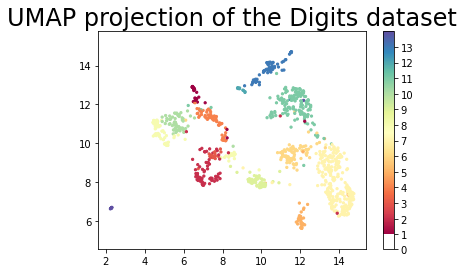

In [68]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=number_lable, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(15)-0.5).set_ticks(np.arange(14))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

In [69]:
from io import BytesIO
from PIL import Image
import base64

In [70]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [71]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [72]:
picture = []
for image in image_paths:
    imhs = plt.imread(image)
    img = cv2.resize(imhs, (32, 32), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    picture.append(gray)
# print(picture)

In [73]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in number_lable]
digits_df['image'] = list(map(embeddable_image, picture))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(13 - x) for x in set(number_lable)],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the oil dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

In [57]:
# print(image_paths)
picture = []
for image in image_paths:
    imhs = plt.imread(image)
    img = cv2.resize(imhs, (32, 32), interpolation=cv2.INTER_CUBIC)
    picture.append(img)
print(picture)
#     print(img.shape)
    

[array([[[172, 171, 167],
        [173, 174, 167],
        [183, 184, 180],
        ...,
        [163, 162, 142],
        [168, 169, 148],
        [141, 148, 151]],

       [[159, 156, 161],
        [167, 162, 155],
        [181, 184, 178],
        ...,
        [177, 178, 163],
        [146, 144, 140],
        [123, 103, 134]],

       [[183, 185, 180],
        [184, 185, 177],
        [182, 187, 180],
        ...,
        [177, 178, 182],
        [168, 171, 150],
        [151, 152, 136]],

       ...,

       [[ 76,  63, 119],
        [141, 136, 139],
        [167, 166, 162],
        ...,
        [176, 176, 166],
        [173, 175, 174],
        [186, 190, 193]],

       [[155, 147, 158],
        [145, 134, 140],
        [167, 164, 149],
        ...,
        [169, 160, 153],
        [167, 162, 156],
        [180, 180, 172]],

       [[182, 185, 178],
        [162, 158, 146],
        [139, 133, 143],
        ...,
        [172, 170, 166],
        [178, 178, 176],
        [172, 168, 176]